In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-03 15:01:03.422660: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## read B-field

In [3]:
dtype = np.float64  # 64-bit floating point
nx,ny,nz = 256,256,64
# Read the binary file
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
#ternd = np.fromfile('../../SyncEmiss/ternd.bin', dtype=dtype).reshape((256,256,64))*0#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))

breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))

B_field = breg+brnd
B_field = jnp.ones_like(breg+brnd)*jnp.array([1,0,0])*6e-6
TE_field = tereg#+ternd

## Calc $\chi_0$

In [5]:
xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')

def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.006)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((nx,ny,nz,3))

In [6]:
sinb = nhats[:,:,:,2]
cosb = jnp.sqrt(1-sinb**2)
cosl = nhats[:,:,:,0]/cosb
sinl = nhats[:,:,:,1]/cosb

In [8]:
%%time
Bz = B_field[...,2]
By = B_field[...,1]
Bx = B_field[...,0]
tanchi0 = (Bz*cosb-sinb*(cosl*Bx+By*sinl))/(Bx*sinl-By*cosl)
chi0 = jnp.arctan(tanchi0)

CPU times: user 57.7 ms, sys: 7.24 ms, total: 65 ms
Wall time: 81.6 ms


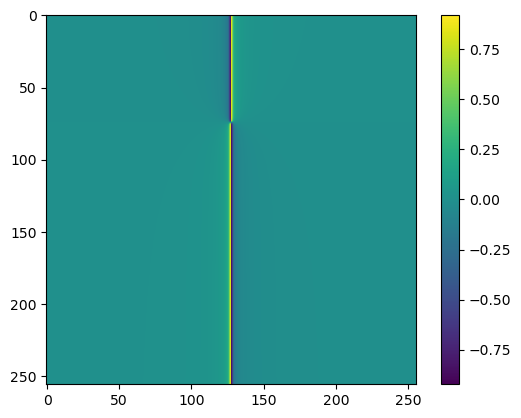

In [11]:
plt.imshow(tanchi0[:,:,32])
plt.colorbar()